# How to apply Support Vector Machines to a Regression task

See title.

### 0. Download the dataset from Kaggle

In [1]:
import os
import zipfile
# import pandas as pd

initial_working_directory = os.getcwd()

kaggle_dataset = "new-york-city-taxi-fare-prediction"

kaggle_json_path = '<path_to_kaggle_json>' # replace with path to your kaggle.json file

os.environ['KAGGLE_CONFIG_DIR'] = kaggle_json_path

target_dir = os.path.join('<base_path>', 'Kaggle', kaggle_dataset) # replace <base_path> with desired base directory

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

os.chdir(target_dir)

In [ ]:
!kaggle competitions download -c {kaggle_dataset}

In [3]:
with zipfile.ZipFile(f'{kaggle_dataset}.zip', 'r') as zip_ref:
    zip_ref.extractall()

### 1. Load the libraries/modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler

### 2. Load the dataset

In [5]:
df = pd.read_csv('train.csv')

In [6]:
os.chdir(initial_working_directory)

In [ ]:
cwd = os.getcwd()
print(cwd)

### 3. Transform the dataset into a DataFrame

In [8]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


### 4. Exploratory Data Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [13]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [14]:
na_cols = df.loc[:, df.isnull().any()].isnull().sum().sort_values(ascending=False)
print(na_cols)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [18]:
df['Fence'].value_counts(dropna=False)

NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

In [19]:
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'MasVnrType', 'Electrical']
df = df.drop(columns=cols_to_drop)

In [21]:
df.isnull().sum().sort_values(ascending=False)

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
               ..
Foundation      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
SalePrice       0
Length: 62, dtype: int64

In [38]:
continuous_cols = []
for col in df.columns:
    if df[col].dtype != 'object' and len(df[col].unique()) > 20:
        continuous_cols.append(col)

for col in continuous_cols:
    print(col)

Id
LotArea
YearBuilt
YearRemodAdd
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
ScreenPorch
MiscVal
SalePrice


In [39]:
categorical_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)

for col in categorical_cols:
    print(col)

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
ExterQual
ExterCond
Foundation
Heating
HeatingQC
CentralAir
KitchenQual
Functional
PavedDrive
SaleType
SaleCondition


In [41]:
numeric_cat_cols = []
for col in df.columns:
    if df[col].dtype != 'object' and len(df[col].unique()) <= 20:
        numeric_cat_cols.append(col)

for col in numeric_cat_cols:
    print(col)

MSSubClass
OverallQual
OverallCond
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
3SsnPorch
PoolArea
MoSold
YrSold


Text(0, 0.5, 'Frequency')

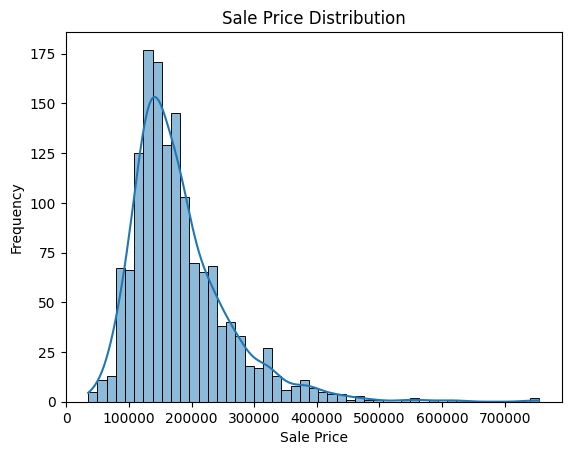

In [22]:
sns.histplot(df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

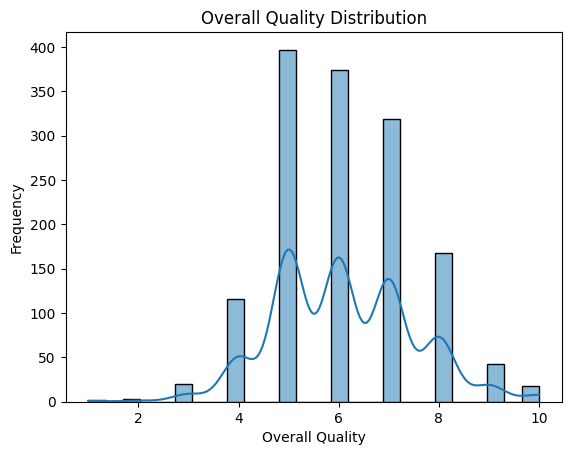

In [23]:
sns.histplot(df['OverallQual'], kde=True)
plt.title('Overall Quality Distribution')
plt.xlabel('Overall Quality')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

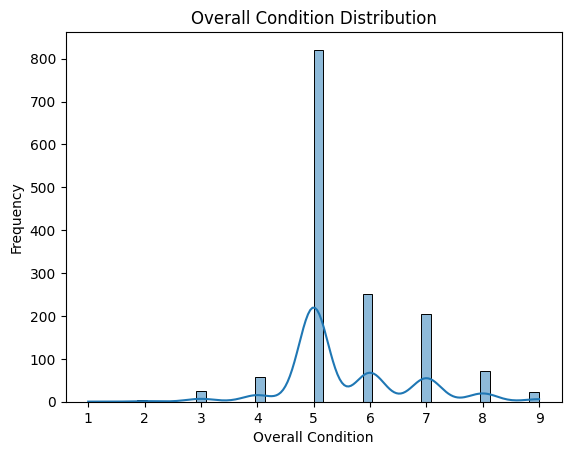

In [27]:
sns.histplot(df['OverallCond'], kde=True)
plt.title('Overall Condition Distribution')
plt.xlabel('Overall Condition')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

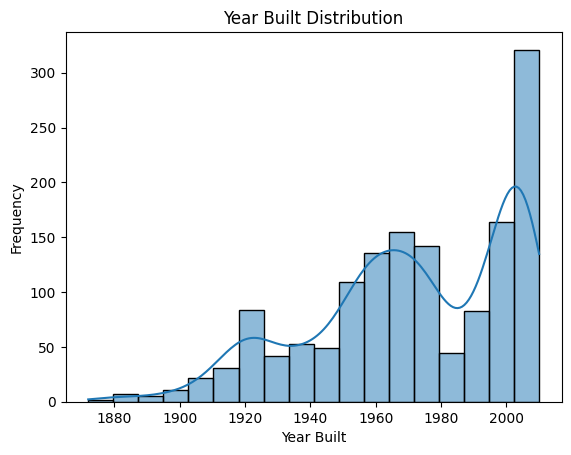

In [24]:
sns.histplot(df['YearBuilt'], kde=True)
plt.title('Year Built Distribution')
plt.xlabel('Year Built')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

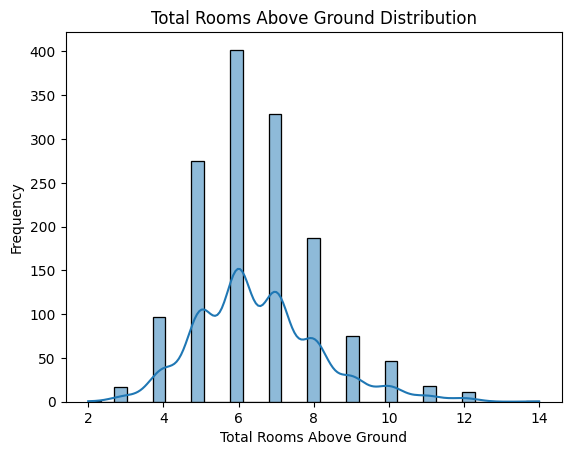

In [25]:
sns.histplot(df['TotRmsAbvGrd'], kde=True)
plt.title('Total Rooms Above Ground Distribution')
plt.xlabel('Total Rooms Above Ground')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

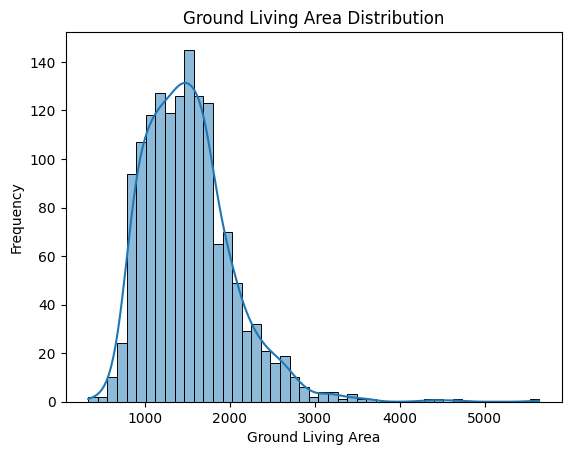

In [26]:
sns.histplot(df['GrLivArea'], kde=True)
plt.title('Ground Living Area Distribution')
plt.xlabel('Ground Living Area')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

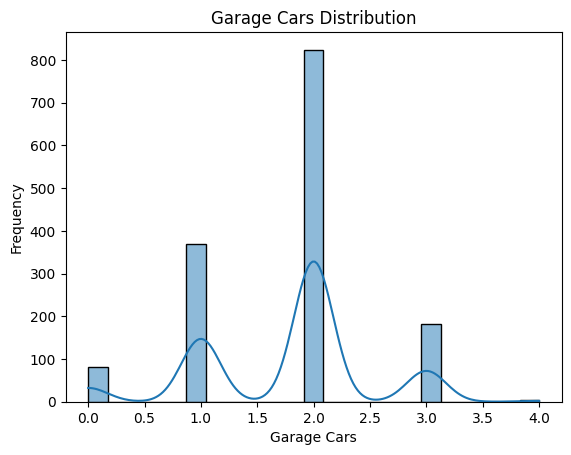

In [28]:
sns.histplot(df['GarageCars'], kde=True)
plt.title('Garage Cars Distribution')
plt.xlabel('Garage Cars')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

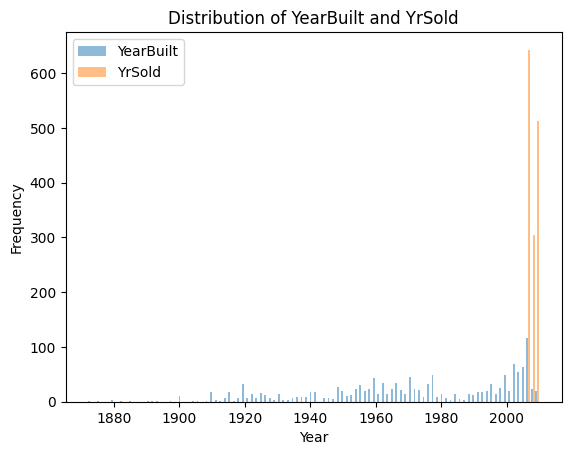

In [32]:
plt.hist([df['YearBuilt'], df['YrSold']], bins=100, alpha=0.5, label=['YearBuilt', 'YrSold'])
plt.legend(loc='upper left')
plt.title('Distribution of YearBuilt and YrSold')
plt.xlabel('Year')
plt.ylabel('Frequency')

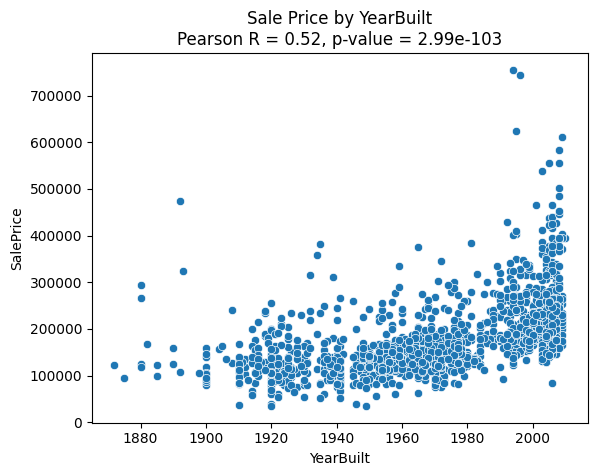

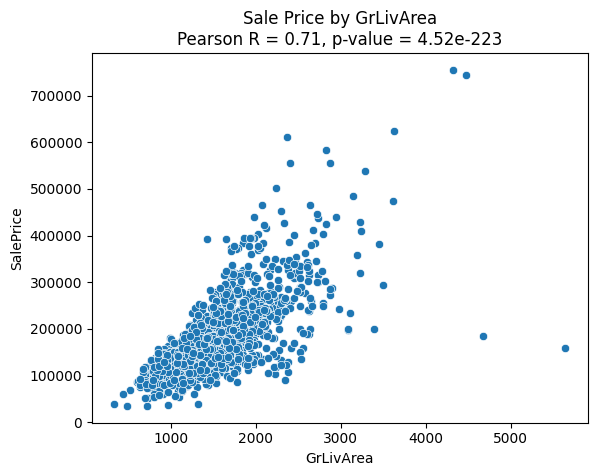

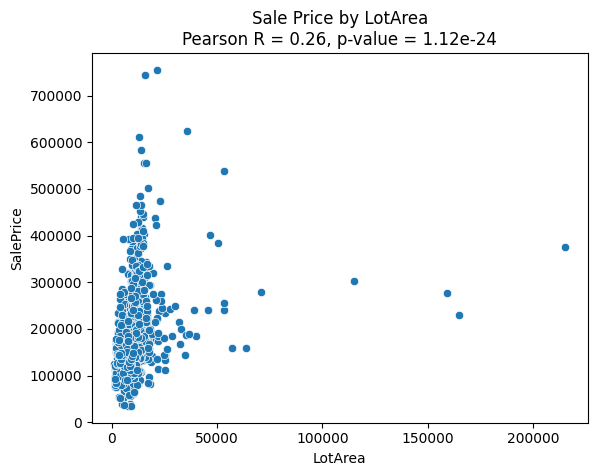

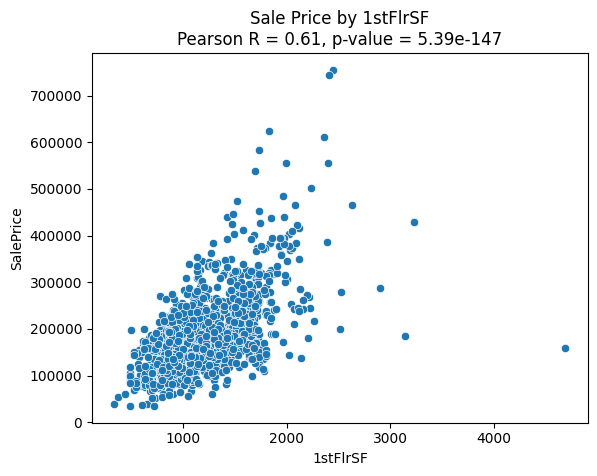

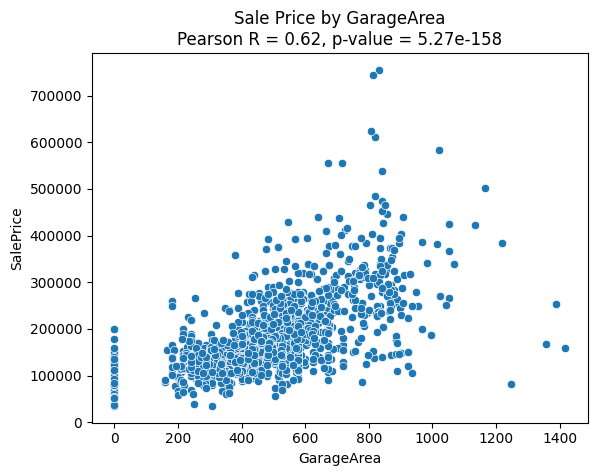

In [52]:
import scipy.stats as stats

features = ['YearBuilt', 'GrLivArea', 'LotArea', '1stFlrSF', 'GarageArea']
    
for feature in features:
    r, p = stats.pearsonr(df[feature], df['SalePrice'])
    sns.scatterplot(x=feature, y='SalePrice', data=df)
    plt.title(f'Sale Price by {feature}\nPearson R = {r:.2f}, p-value = {p:.2e}', fontsize=12)  # include Pearson R and p-value in title
    plt.show()

Text(0.5, 1.0, 'Sale Price by Year Built')

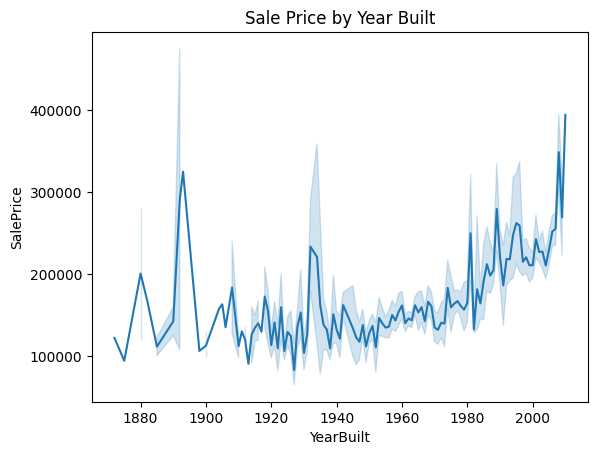

In [44]:
sns.lineplot(x='YearBuilt', y='SalePrice', data=df)
plt.title('Sale Price by Year Built')

Text(0.5, 1.0, 'Sale Price by Year Built')

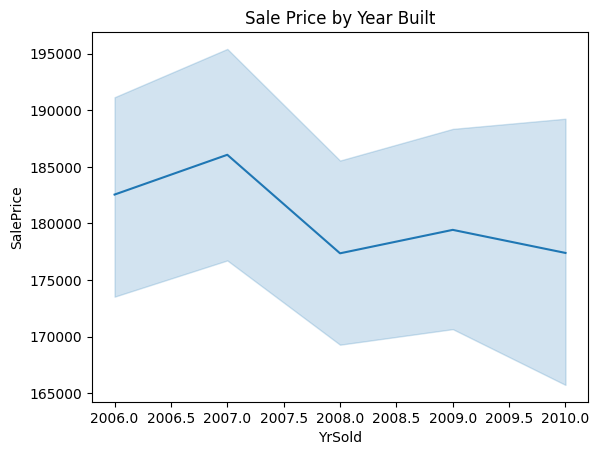

In [45]:
sns.lineplot(x='YrSold', y='SalePrice', data=df)
plt.title('Sale Price by Year Built')

Text(0.5, 1.0, 'Sale Price by Year Sold')

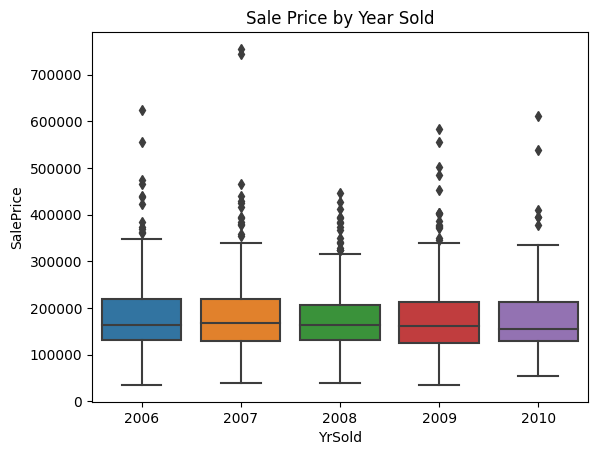

In [54]:
sns.boxplot(x='YrSold', y='SalePrice', data=df)
plt.title('Sale Price by Year Sold')

In [55]:
df.shape

(1460, 62)

In [60]:
df[df['SalePrice'] == 0]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [69]:
categorical_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)

for col in categorical_cols:
    print(col)

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
ExterQual
ExterCond
Foundation
Heating
HeatingQC
CentralAir
KitchenQual
Functional
PavedDrive
SaleType
SaleCondition


In [71]:
categorical_dummies = pd.DataFrame()

for col in categorical_cols:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    categorical_dummies = pd.concat([categorical_dummies, dummies], axis=1)

In [85]:
categorical_dummies.describe()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.044521,0.010959,0.788356,0.149315,0.995890,0.028082,0.006849,0.633562,0.034247,0.024658,...,0.003425,0.003425,0.083562,0.002055,0.867808,0.002740,0.008219,0.013699,0.820548,0.085616
std,0.206319,0.104145,0.408614,0.356521,0.063996,0.165264,0.082505,0.481996,0.181924,0.155132,...,0.058440,0.058440,0.276824,0.045299,0.338815,0.052289,0.090317,0.116277,0.383862,0.279893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df = pd.concat([df, categorical_dummies], axis=1)

### 5. Split the data and standardise features

In [79]:
df = df.drop(columns=['Id'])
X = df.drop(columns=['SalePrice'])
X = df.drop(columns=categorical_cols)
y = df['SalePrice']

In [81]:
print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', type(X))
print('X type:', type(y))

X shape: (1460, 189)
y shape: (1460,)
X type: <class 'pandas.core.frame.DataFrame'>
X type: <class 'pandas.core.series.Series'>


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6. Set model, fit, and get predictions

In [86]:
svm = SVR()
svm.fit(X_train_scaled, y_train)

SVR()

In [87]:
y_pred_svm = svm.predict(X_test_scaled)

### 7. Evaluate the model's performance

In [88]:
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print('SVM Regression Performance:')
print('Mean Squared Error:', mse_svm)
print('R-squared:', r2_svm)

SVM Regression Performance:
Mean Squared Error: 6194681389.139136
R-squared: -0.040584529098578015


### 8. Use GridSearchCV to find the best hyperparameters for the SVM regressor

In [89]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale'],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [90]:
print('Best Hyperparameters for SVM Regressor:')
print(svm_cv.best_params_)

Best Hyperparameters for SVM Regressor:
{'C': 10, 'gamma': 1, 'kernel': 'poly'}


### 9. Refit the SVM regressor with the best hyperparameters

In [91]:
best_params = svm_cv.best_params_
svm_best = SVR(
    C=best_params['C'],
    gamma=best_params['gamma'],
    kernel=best_params['kernel']
)
svm_best.fit(X_train_scaled, y_train)

SVR(C=10, gamma=1, kernel='poly')

### 10. Make predictions on the testing data using the refitted SVM regressor

In [92]:
y_pred_svm_best = svm_best.predict(X_test_scaled)

### 11. Evaluate the performance of the refitted SVM regressor using mean squared error and R-squared

In [93]:
mse_svm_best = mean_squared_error(y_test, y_pred_svm_best)
r2_svm_best = r2_score(y_test, y_pred_svm_best)
print('Refitted SVM Regression Performance:')
print('Mean Squared Error:', mse_svm_best)
print('R-squared:', r2_svm_best)

Refitted SVM Regression Performance:
Mean Squared Error: 4394730622.405449
R-squared: 0.26177176710836647


### 12. Compare the performance of the initial SVM regressor and the refitted SVM regressor

In [96]:
mae_svm = mean_absolute_error(y_test, y_pred_svm)
medae_svm = median_absolute_error(y_test, y_pred_svm)

mae_svm_best = mean_absolute_error(y_test, y_pred_svm_best)
medae_svm_best = median_absolute_error(y_test, y_pred_svm_best)

print('Initial SVM Regression Performance:')
print('Mean Squared Error:', mse_svm)
print('Mean Absolute Error:', mae_svm)
print('Median Absolute Error:', medae_svm)
print('R-squared:', r2_svm)
print()
print('Refitted SVM Regression Performance:')
print('Mean Squared Error:', mse_svm_best)
print('Mean Absolute Error:', mae_svm_best)
print('Median Absolute Error:', medae_svm_best)
print('R-squared:', r2_svm_best)

Initial SVM Regression Performance:
Mean Squared Error: 6194681389.139136
Mean Absolute Error: 55151.21869331169
Median Absolute Error: 36477.282530334385
R-squared: -0.040584529098578015

Refitted SVM Regression Performance:
Mean Squared Error: 4394730622.405449
Mean Absolute Error: 17757.663444723625
Median Absolute Error: 9527.064851148549
R-squared: 0.26177176710836647


Performance improved significantly with the refitted SVM, but we'd need to recheck everything (from data manipulation to parameters passed in the GridSearchCV) to make it better.